In [1]:
import json
import pandas as pd
import common

In [2]:
word_list = []
with open(r"word_list\spanish\es_50k.txt", encoding="utf-8") as file:
    for line in file.readlines():
        items = line.split()
        *words, count = items
        word = " ".join(words)
        word_list.append([word, int(count)])
print(word_list[:5])

[['de', 14459520], ['que', 14421005], ['no', 12379505], ['a', 9549646], ['la', 9125471]]


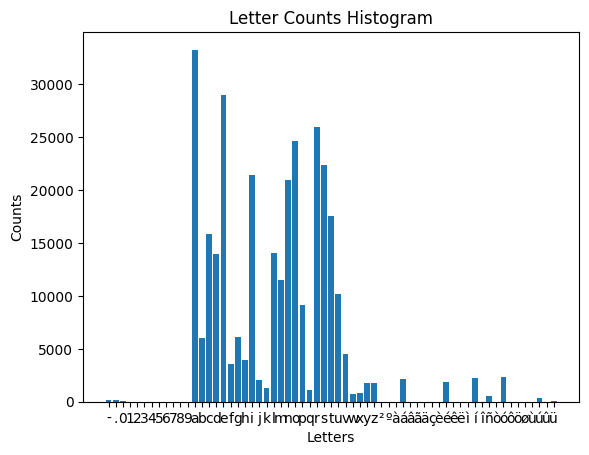

all alphabets: -.0123456789abcdefghijklmnopqrstuvwxyz²ºàáâãäçèéêëìíîñòóôöøùúûü
non_alphas: -.0123456789²
less_than_10: ºâäçêëìîòôöøùû
outliers: àãèü
remainings: abcdefghijklmnopqrstuvwxyzáéíñóú


In [3]:
df = pd.DataFrame(word_list)
df.columns = ["word", "count"]
common.plot_count_graph(df)
common.analyze_alphabets(df)

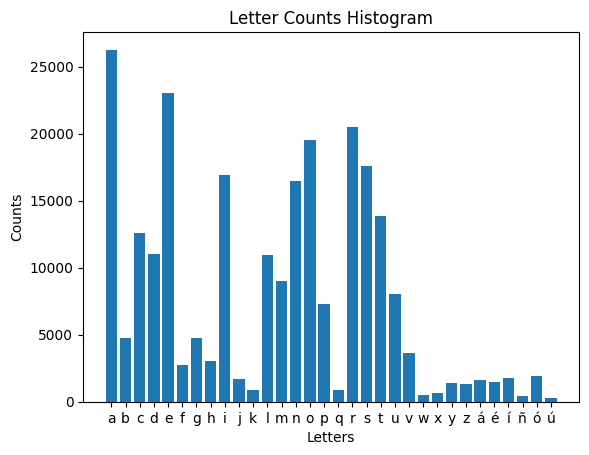

,word,count,word_len
0,a,9549646,1
1,aa,865,2
2,aaa,281,3
3,aaaah,348,5
4,aaah,848,4


In [4]:
# only lowercase word
df["word"] = df["word"].astype(str).apply(lambda x: x.lower())
agg_functions = {"word": "first", "count": "sum"}
df = df.groupby(df["word"], as_index=False).aggregate(agg_functions)

# allowed alphabets
allowed_alphabets = "abcdefghijklmnopqrstuvwxyzáéíñóú"
df = df[df["word"].str.contains(f"^[{allowed_alphabets}]+$")]

# frequent words
df = df[df["count"] > df["count"].quantile(0.2)]

df["word_len"] = df["word"].apply(len)
df = df.sort_values(by=["word"]).reset_index(drop=True)

common.plot_count_graph(df)
df.head()

In [5]:
df.dtypes

word        object
count        int64
word_len     int64
dtype: object

In [6]:
df.describe()

,count,word_len
count,3.957500e+04,39575.000000
mean,1.035946e+04,7.498294
std,1.779946e+05,2.366759
min,2.750000e+02,1.000000
25%,4.460000e+02,6.000000
50%,8.460000e+02,7.000000
75%,2.324000e+03,9.000000
max,1.445952e+07,19.000000


In [7]:
df[(df["word_len"] >= 3) & (df["word_len"] <= 5) & (df["count"] > 1)].describe()

,count,word_len
count,7.908000e+03,7908.000000
mean,2.161741e+04,4.437911
std,2.137391e+05,0.702712
min,2.750000e+02,3.000000
25%,5.050000e+02,4.000000
50%,1.146000e+03,5.000000
75%,4.132500e+03,5.000000
max,1.442100e+07,5.000000


In [8]:
df.query("'libro' in word or 'libros' in word")

,word,count,word_len
22313,libro,64445,5
22314,libros,28603,6


In [9]:
difficulties = {"easy": 0.6, "medium": 0.4, "hard": 0.2, "all": 0}
min_len = 4
max_len = 5

for name, percentile in difficulties.items():
    dfs_filtered: list[pd.DataFrame] = []
    lengths: list[str] = []
    for l in range(min_len, max_len + 1):
        df_len = df[df["word_len"] == l]
        cutoff = df_len["count"].quantile(percentile)
        dfs_filtered.append(
            df_len[df_len["count"] > cutoff]
            .sort_values(by=["count"], ascending=False)
            .reset_index(drop=True)
        )
        lengths.append(f"len{l}: #{len(dfs_filtered[-1])}")
    df_filtered = pd.concat(dfs_filtered)

    print(", ".join(lengths))

    with open(rf"vocabs\es\es-{name}.json", "w") as f:
        data = df_filtered["word"].sort_values().tolist()
        json.dump(data, f)
        print(f"{f.name}: {len(df_filtered)} words")

len4: #995, len5: #1776
vocabs\es\es-easy.json: 2771 words
len4: #1490, len5: #2662
vocabs\es\es-medium.json: 4152 words
len4: #1986, len5: #3551
vocabs\es\es-hard.json: 5537 words
len4: #2486, len5: #4441
vocabs\es\es-all.json: 6927 words
